In [1]:
import os
import pickle
import quandl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.offline as py
import plotly.graph_objs as go
import plotly.figure_factory as ff
from datetime import datetime
py.init_notebook_mode(connected=True)

In [2]:
# To avoid usage Limits
quandl.ApiConfig.api_key = "5r9wbefpwNFwVCRcY2KV"

In [3]:
# extract bitcoin price in US dollar on exchange Coinbase
btc_usd_price_coinbase = quandl.get("BCHARTS/COINBASEUSD", authtoken="5r9wbefpwNFwVCRcY2KV")
btc_usd_price_coinbase.head(2)

Open    High     Low   Close  Volume (BTC)  Volume (Currency)  \
Date                                                                          
2015-02-04  228.77  230.25  221.85  227.11   3344.120783       7.578076e+05   
2015-05-11  241.59  245.49  239.50  242.86   6176.481242       1.498052e+06   

            Weighted Price  
Date                        
2015-02-04      226.608934  
2015-05-11      242.541273

In [4]:
btc_price_trace = go.Scatter(x = btc_usd_price_coinbase.index, y = btc_usd_price_coinbase['Weighted Price'])
data = [btc_price_trace]
layout = go.Layout(
    title='Bitcoin Price in US Dollars on Coinbase',
    xaxis=dict(title='Date'),
    yaxis=dict(title='BTC Price (USD)')
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig)

In [5]:
# extract bitcoin price in US dollars on 9 more BTC exchanges
exchanges = ['BITBAY', 'BITSTAMP', 'BTCALPHA', 'BTCC', 'CEX', 'COINSBANK', 'OKCOIN', 'ITBIT', 'KRAKEN']

exchange_data = {}

exchange_data['COINBASE'] = btc_usd_price_coinbase

for exchange in exchanges:
    exchange_code = 'BCHARTS/{}USD'.format(exchange)
    btc_exchange_df = quandl.get(exchange_code)
    exchange_data[exchange] = btc_exchange_df

In [6]:
def merge_dfs_on_column(dataframes, labels, col):
    # Merge a single column of each dataframe into a new combined dataframe
    series_dict = {}
    for index in range(len(dataframes)):
        series_dict[labels[index]] = dataframes[index][col]
        
    return pd.DataFrame(series_dict)

In [7]:
# Merge the BTC price data series into a single dataframe
btc_usd_datasets = merge_dfs_on_column(list(exchange_data.values()), list(exchange_data.keys()), 'Weighted Price')

# Remove "0" values
btc_usd_datasets.replace(0, np.nan, inplace=True)

In [8]:
btc_usd_datasets.tail(2)

BITBAY     BITSTAMP     BTCALPHA         BTCC          CEX  \
Date                                                                          
2018-04-28  9060.957229  9238.002473  9525.735680  9114.578402  9267.897815   
2018-04-29  9205.713948  9354.092334  9644.001769  9324.815260  9350.436681   

               COINBASE    COINSBANK  ITBIT       KRAKEN       OKCOIN  
Date                                                                   
2018-04-28  9245.765490  9032.539086    NaN  9257.586021  9338.542250  
2018-04-29  9359.029243  9120.638907    NaN  9367.415953  9466.534622

In [9]:
def df_scatter(df, title, seperate_y_axis=False, y_axis_label='BTC Price (USD)', scale='linear', initial_hide=False):
    # Generate a scatter plot of the entire dataframe
    label_arr = list(df)
    series_arr = list(map(lambda col: df[col], label_arr))
    
    layout = go.Layout(
        title=title,
        legend=dict(orientation="h"),
        xaxis=dict(type='date'),
        yaxis=dict(
            title=y_axis_label,
            showticklabels= not seperate_y_axis,
            type=scale
        )
    )
    
    y_axis_config = dict(
        overlaying='y',
        showticklabels=False,
        type=scale )
    
    visibility = 'visible'
    if initial_hide:
        visibility = 'legendonly'
        
    # Form Trace For Each Series
    trace_arr = []
    for index, series in enumerate(series_arr):
        trace = go.Scatter(
            x=series.index, 
            y=series, 
            name=label_arr[index],
            visible=visibility
        )
        
        # Add seperate axis for the series
        if seperate_y_axis:
            trace['yaxis'] = 'y{}'.format(index + 1)
            layout['yaxis{}'.format(index + 1)] = y_axis_config    
        trace_arr.append(trace)

    fig = go.Figure(data=trace_arr, layout=layout)
    py.iplot(fig)

In [10]:
# Remove "0" values
btc_usd_datasets.replace(0, np.nan, inplace=True)

# Plot all of the BTC exchange prices
df_scatter(btc_usd_datasets, 'Bitcoin Price on Difffenrent Exchanges')

In [11]:
# Calculate the average BTC price as a new column
btc_usd_datasets['avg_btc_price_usd'] = btc_usd_datasets.mean(axis=1)
btc_usd_datasets.head(2)

BITBAY  BITSTAMP  BTCALPHA  BTCC  CEX  COINBASE  COINSBANK  ITBIT  \
Date                                                                            
2011-09-13     NaN  5.929231       NaN   NaN  NaN       NaN        NaN    NaN   
2011-09-14     NaN  5.590798       NaN   NaN  NaN       NaN        NaN    NaN   

            KRAKEN  OKCOIN  avg_btc_price_usd  
Date                                           
2011-09-13     NaN     NaN           5.929231  
2011-09-14     NaN     NaN           5.590798

In [12]:
btc_average_price = btc_usd_datasets.filter(items=['avg_btc_price_usd'])
btc_average_price.to_csv('btc_average_price.csv', index=True)
btc_average_price.head(2)

avg_btc_price_usd
Date                         
2011-09-13           5.929231
2011-09-14           5.590798

In [13]:
# Plot the average BTC price
btc_price_trace = go.Scatter(x = btc_average_price.index, y = btc_average_price['avg_btc_price_usd'])
data = [btc_price_trace]
layout = go.Layout(
    title='Bitcoin Average Price in US Dollars',
    xaxis=dict(title='Date'),
    yaxis=dict(title='BTC Price (USD)')
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig)

# Bitcoin Mining Statistics

In [14]:
btc_mining_statistics = quandl.get("BITCOINWATCH/MINING", authtoken="5r9wbefpwNFwVCRcY2KV")
btc_mining_statistics.head(2)

Total BTC    Market Cap  Transactions last 24h  \
Date                                                          
2013-08-26  11608775.0  1.406983e+09                53292.0   
2013-08-27  11612775.0  1.504095e+09                57316.0   

            Transactions avg. per hour  Bitcoins sent last 24h  \
Date                                                             
2013-08-26                     2220.50               641072.88   
2013-08-27                     2388.17               882731.69   

            Bitcoins sent avg. per hour     Count  Blocks last 24h  \
Date                                                                 
2013-08-26                     26711.37  254350.0            165.0   
2013-08-27                     36780.49  254510.0            171.0   

            Blocks avg. per hour  Difficulty  Next Difficulty  \
Date                                                            
2013-08-26                  6.88  65750060.0       68498336.0   
2013-08-27                  7.13  65750060.0       70053502.0   

            Network Hashrate Terahashs  Network Hashrate PetaFLOPS  
Date                                                                
2013-08-26                      490.33                     6227.19  
2013-08-27                      501.46                     6368.57

In [15]:
# Calculate the correlation between bition average price and mining difficulty
price_difficulty = pd.concat([btc_average_price, btc_mining_statistics], axis=1)
price_difficulty = price_difficulty.filter(items=['avg_btc_price_usd', 'Difficulty'])
price_difficulty.corr(method='pearson')

avg_btc_price_usd  Difficulty
avg_btc_price_usd           1.000000    0.806695
Difficulty                  0.806695    1.000000

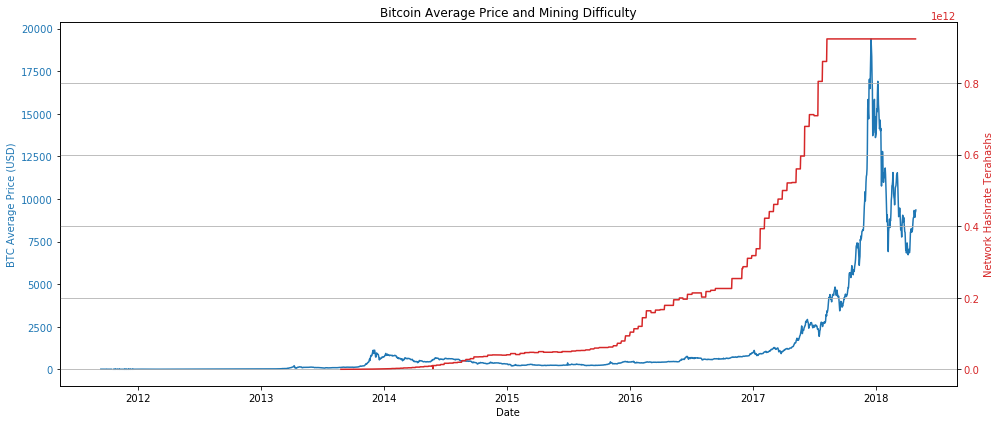

In [43]:
x1 = btc_average_price.index
y1 = btc_average_price['avg_btc_price_usd']
x2 = btc_mining_statistics.index
y2 = btc_mining_statistics['Difficulty']
fig, ax1 = plt.subplots(figsize=(14, 6))

color = 'tab:blue'
ax1.set_xlabel('Date')
ax1.set_ylabel('BTC Average Price (USD)', color=color)
ax1.plot(x1, y1, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:red'
ax2.set_ylabel('Network Hashrate Terahashs', color=color)  # we already handled the x-label with ax1
ax2.plot(x2, y2, color=color)
ax2.tick_params(axis='y', labelcolor=color)
plt.title('Bitcoin Average Price and Mining Difficulty')
plt.grid(True)
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

In [17]:
# Conclusion: The correlation between bitcoin average price and mining difficulty is as high as 0.81, 
# which means they are highly positively correlated. The bitcoin price increased with the mining 
# difficulty from late 2014 to late 2017. Hence, the bition mining difficulty can serve as a leading
# indicator to prdict bitcoin price.

# Bitcoin and S&P 500

In [18]:
sp500 = pd.read_csv('S&P500.csv')
# print(sp500.dtypes)
sp500['Date'] = sp500['Date'].astype('datetime64[ns]')
# print(sp500.dtypes)
sp500 = sp500.set_index('Date')
sp500.tail(2)

Open         High          Low        Close    Adj Close  \
Date                                                                          
2018-04-26  2651.649902  2676.479980  2647.159912  2666.939941  2666.939941   
2018-04-27  2675.469971  2677.350098  2659.010010  2669.909912  2669.909912   

                Volume  
Date                    
2018-04-26  3665720000  
2018-04-27  3219030000

In [19]:
bitcoin_sp500 = pd.concat([sp500, btc_usd_datasets], axis = 1, join='inner')
bitcoin_sp500 = bitcoin_sp500.filter(items = ['Close', 'avg_btc_price_usd'])
bitcoin_sp500.corr(method='pearson')

Close  avg_btc_price_usd
Close              1.000000           0.655289
avg_btc_price_usd  0.655289           1.000000

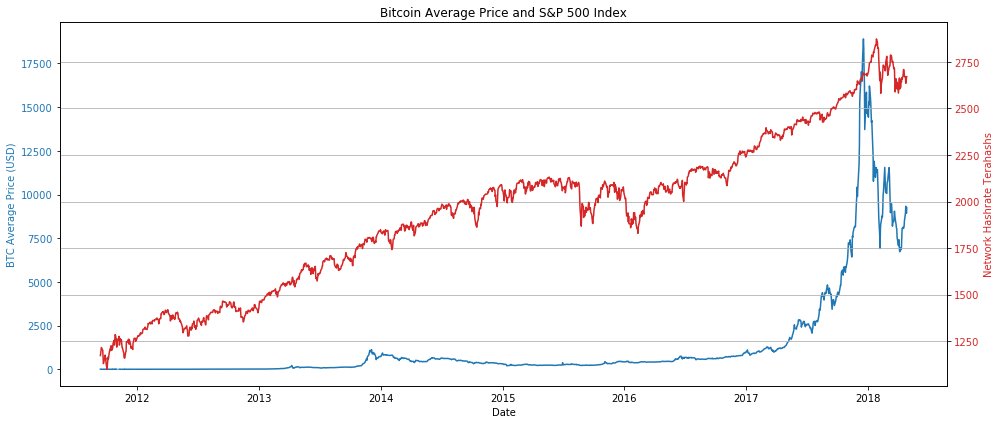

In [20]:
x = bitcoin_sp500.index
y1 = bitcoin_sp500.avg_btc_price_usd
y2 = bitcoin_sp500.Close
fig, ax1 = plt.subplots(figsize=(14, 6))

color = 'tab:blue'
ax1.set_xlabel('Date')
ax1.set_ylabel('BTC Average Price (USD)', color=color)
ax1.plot(x, y1, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:red'
ax2.set_ylabel('Network Hashrate Terahashs', color=color)  # we already handled the x-label with ax1
ax2.plot(x, y2, color=color)
ax2.tick_params(axis='y', labelcolor=color)
plt.title('Bitcoin Average Price and S&P 500 Index')
plt.grid(True)
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

In [21]:
def bitcoin_sp500_correlation_year_dependence(years):
    correlations = len(years)*[0]
    for i in range(len(years)):
        bitcoin_sp500_correlation = bitcoin_sp500[bitcoin_sp500.index.year == years[i]]
        correlations[i] = bitcoin_sp500_correlation.corr(method='pearson')['avg_btc_price_usd'][0]
        
        x = bitcoin_sp500_correlation.index
        y1 = bitcoin_sp500_correlation.avg_btc_price_usd
        y2 = bitcoin_sp500_correlation.Close
        fig, ax1 = plt.subplots(figsize=(14, 6))

        color = 'tab:blue'
        ax1.set_xlabel('Date')
        ax1.set_ylabel('BTC Average Price (USD)', color=color)
        ax1.plot(x, y1, color=color)
        ax1.tick_params(axis='y', labelcolor=color)

        ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

        color = 'tab:red'
        ax2.set_ylabel('S&P 500 Index', color=color)  # we already handled the x-label with ax1
        ax2.plot(x, y2, color=color)
        ax2.tick_params(axis='y', labelcolor=color)
        title = 'Bitcoin Average Price and S&P 500 Index in ' + str(years[i])
        plt.title(title)
        plt.grid(True)
        fig.tight_layout()  # otherwise the right y-label is slightly clipped
        plt.show()
    
    year_corrletion = pd.DataFrame({'Year': years, 'Bitcoin price and S&P 500 index Correlation': correlations})
    year_corrletion = year_corrletion.set_index('Year')
    return year_corrletion

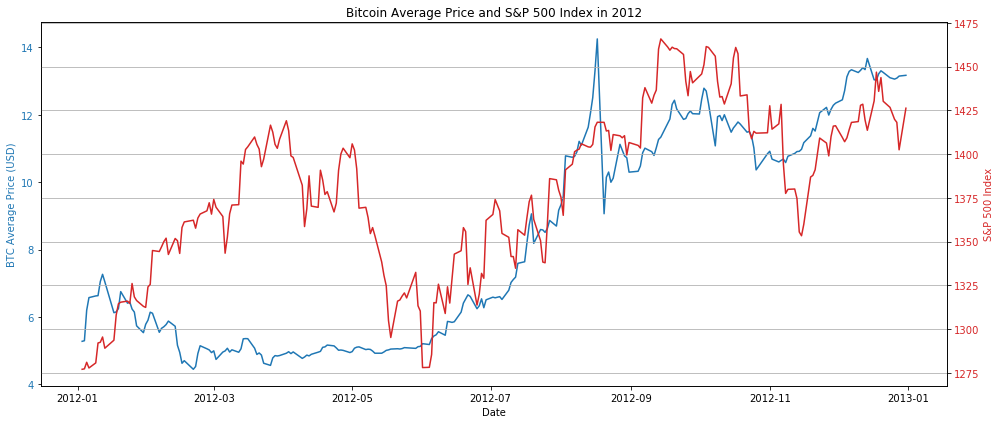

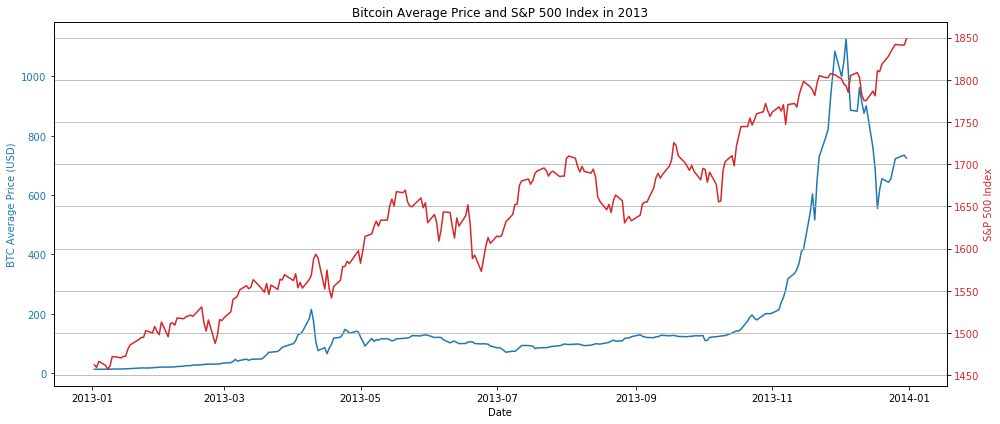

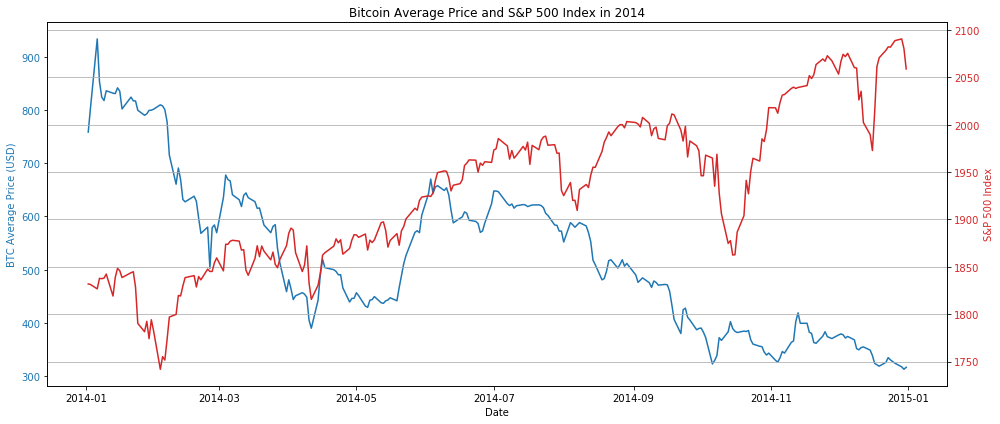

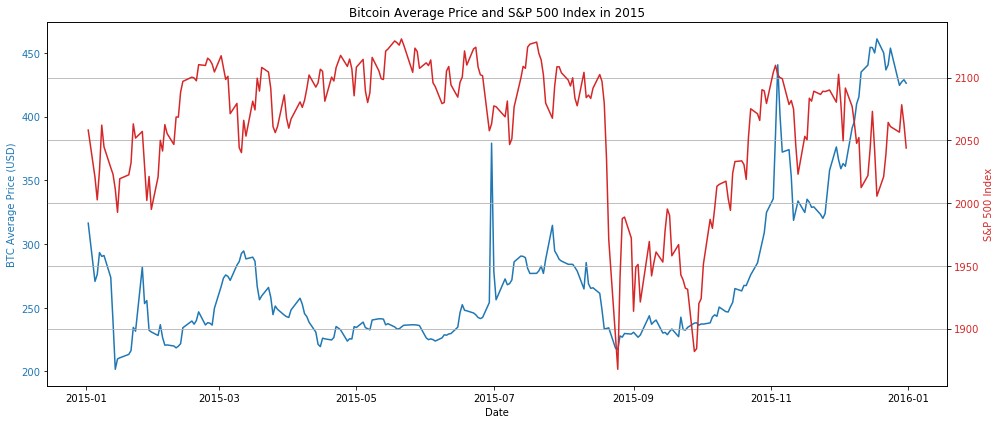

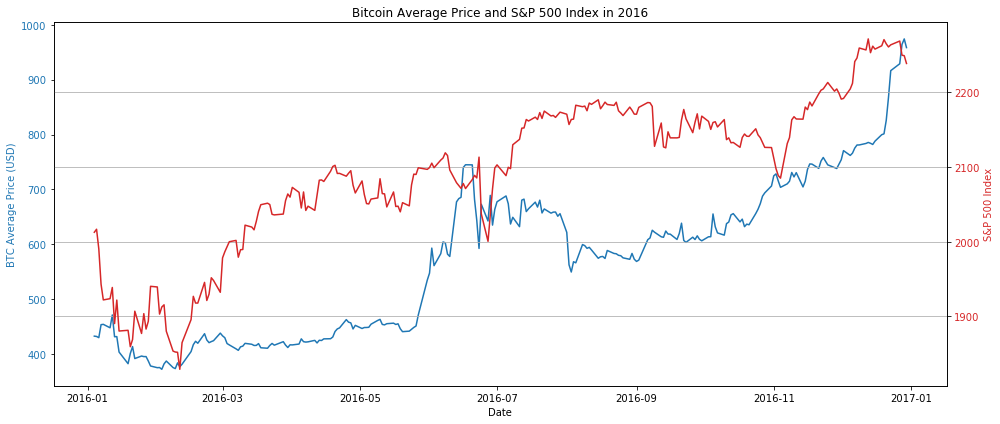

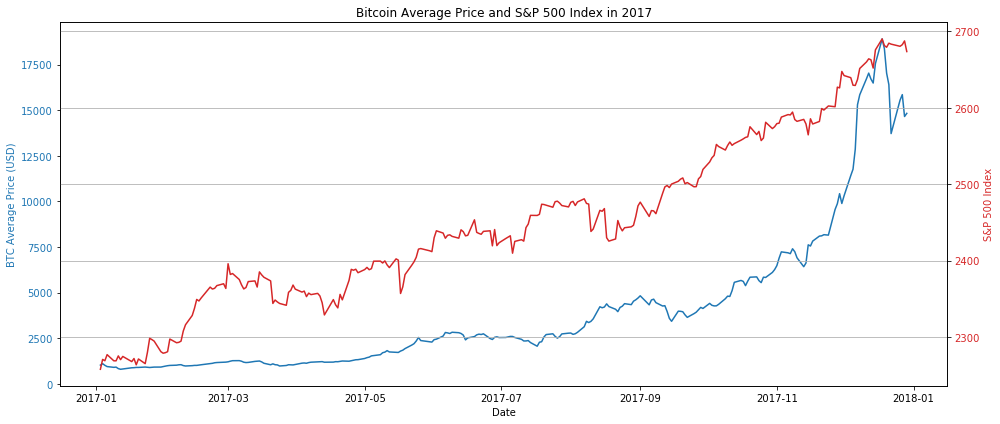

Bitcoin price and S&P 500 index Correlation
Year                                             
2012                                     0.678277
2013                                     0.717019
2014                                    -0.642425
2015                                     0.096809
2016                                     0.805067
2017                                     0.872890

In [22]:
years = [2012, 2013, 2014, 2015, 2016, 2017]
bitcoin_sp500_year_corrletion = bitcoin_sp500_correlation_year_dependence(years)
bitcoin_sp500_year_corrletion

In [23]:
# Conclusion: The overall correlation between bitcoin average price and S&P 500 index is 0.66.
# Only in 2014, bitcoin average price and S&P 500 index were negatively correlated.
# Most of the times, bitcoin average price and S&P 500 index were highly positively correlated,
# especially in 2016 and 2017. The S&P 500 index increased with the bitcoin average price. 
# Hence, the bition average price can be used to forecast the overall US stock market sentiment.

# Bitcoin and Crude Oil

In [24]:
crude_oil_price = quandl.get("EIA/PET_RWTC_D", start_date="2011-09-13", end_date="20018-04-28")
crude_oil_price.head(2)

Value
Date             
2011-09-13  90.21
2011-09-14  88.91

In [25]:
bitcoin_crude_oil = pd.concat([btc_usd_datasets, crude_oil_price], axis=1)
bitcoin_crude_oil['crude_oil_price'] = bitcoin_crude_oil.Value
bitcoin_crude_oil = bitcoin_crude_oil.filter(items=['avg_btc_price_usd', 'crude_oil_price'])
bitcoin_crude_oil.corr(method='pearson')

avg_btc_price_usd  crude_oil_price
avg_btc_price_usd            1.00000         -0.22573
crude_oil_price             -0.22573          1.00000

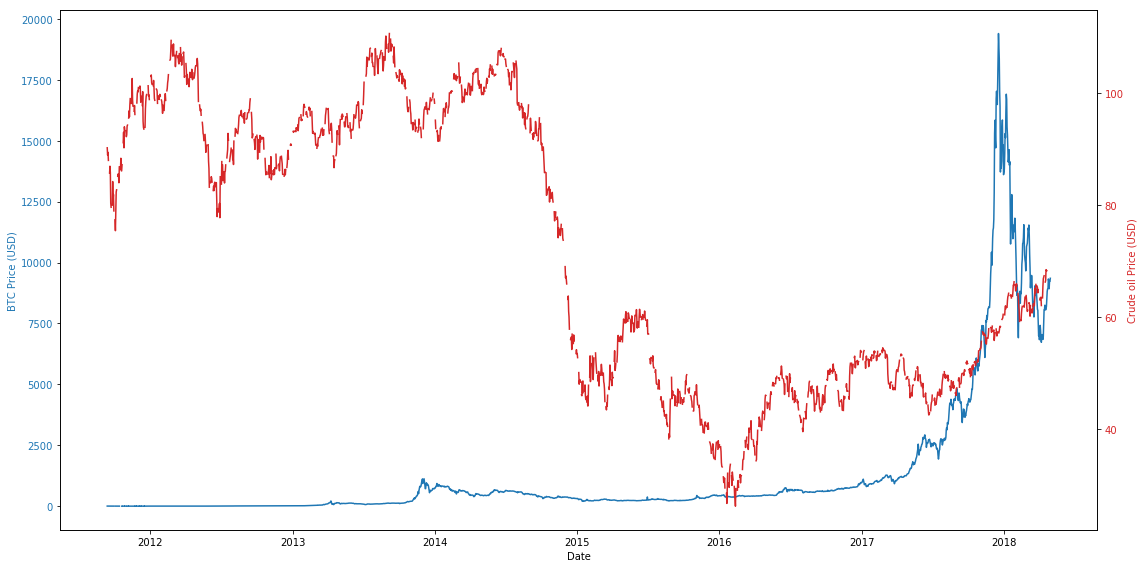

In [26]:
x = bitcoin_crude_oil.index
y1 = bitcoin_crude_oil.avg_btc_price_usd
y2 = bitcoin_crude_oil.crude_oil_price

fig, ax1 = plt.subplots(figsize=(16, 8))

color = 'tab:blue'
ax1.set_xlabel('Date')
ax1.set_ylabel('BTC Price (USD)', color=color)
ax1.plot(x, y1, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:red'
ax2.set_ylabel('Crude oil Price (USD)', color=color)  # we already handled the x-label with ax1
ax2.plot(x, y2, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

In [27]:
def bitcoin_crude_oil_correlation_year_dependence(years):
    correlations = len(years)*[0]
    for i in range(len(years)):
        bitcoin_crude_oil_correlation = bitcoin_crude_oil[bitcoin_crude_oil.index.year == years[i]]
        correlations[i] = bitcoin_crude_oil_correlation.corr(method='pearson')['crude_oil_price'][0]
        
        x = bitcoin_crude_oil_correlation.index
        y1 = bitcoin_crude_oil_correlation.avg_btc_price_usd
        y2 = bitcoin_crude_oil_correlation.crude_oil_price
        fig, ax1 = plt.subplots(figsize=(14, 6))

        color = 'tab:blue'
        ax1.set_xlabel('Date')
        ax1.set_ylabel('BTC Average Price (USD)', color=color)
        ax1.plot(x, y1, color=color)
        ax1.tick_params(axis='y', labelcolor=color)

        ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

        color = 'tab:red'
        ax2.set_ylabel('Crude Oil Price (USD)', color=color)  # we already handled the x-label with ax1
        ax2.plot(x, y2, color=color)
        ax2.tick_params(axis='y', labelcolor=color)
        title = 'Bitcoin Average Price and S&P 500 Index in ' + str(years[i])
        plt.title(title)
        plt.grid(True)
        fig.tight_layout()  # otherwise the right y-label is slightly clipped
        plt.show()
    
    year_corrletion = pd.DataFrame({'Year': years, 'Bitcoin price and Crude Oil Price Correlation': correlations})
    year_corrletion = year_corrletion.set_index('Year')
    return year_corrletion

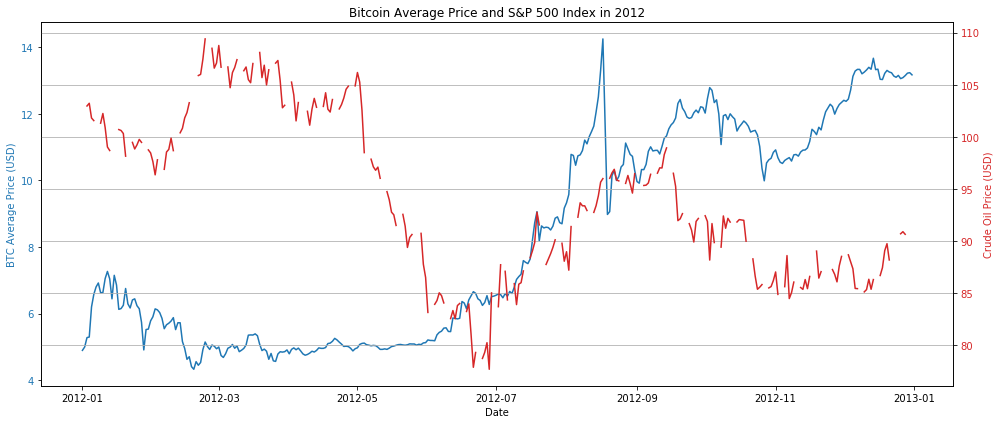

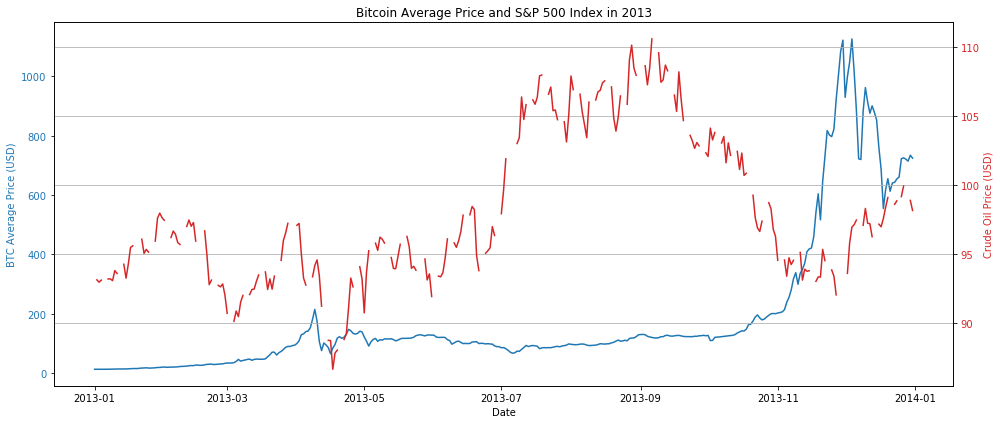

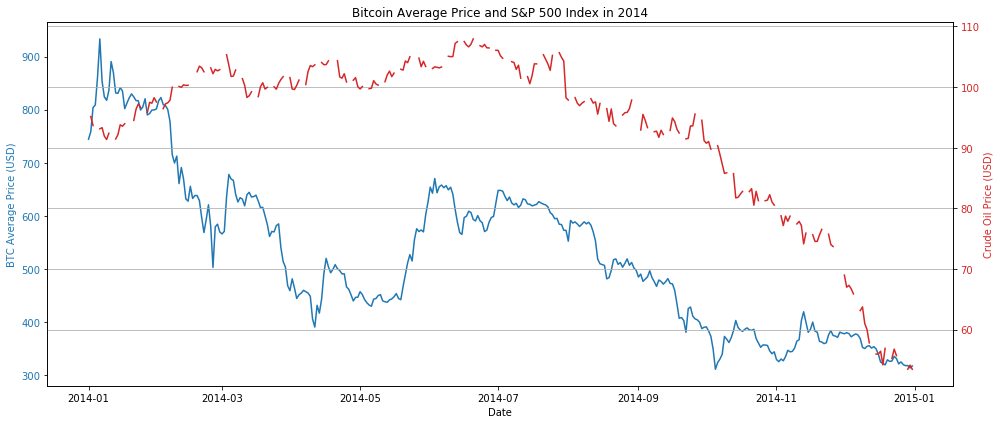

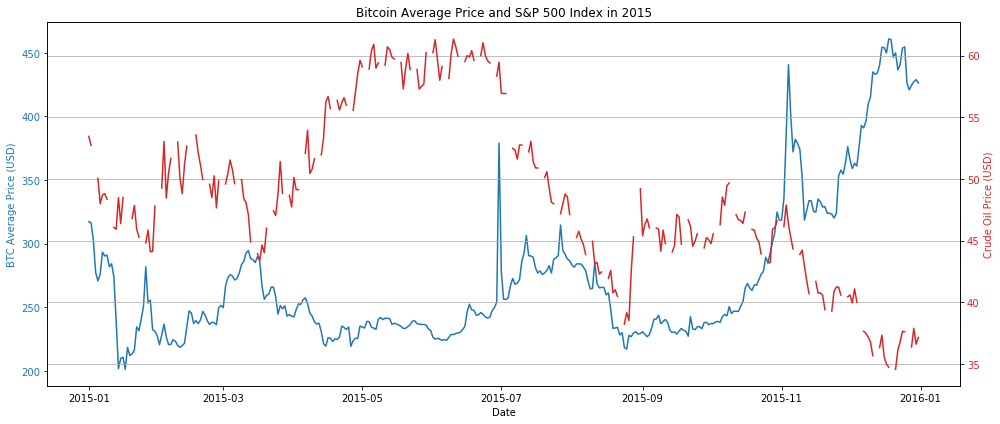

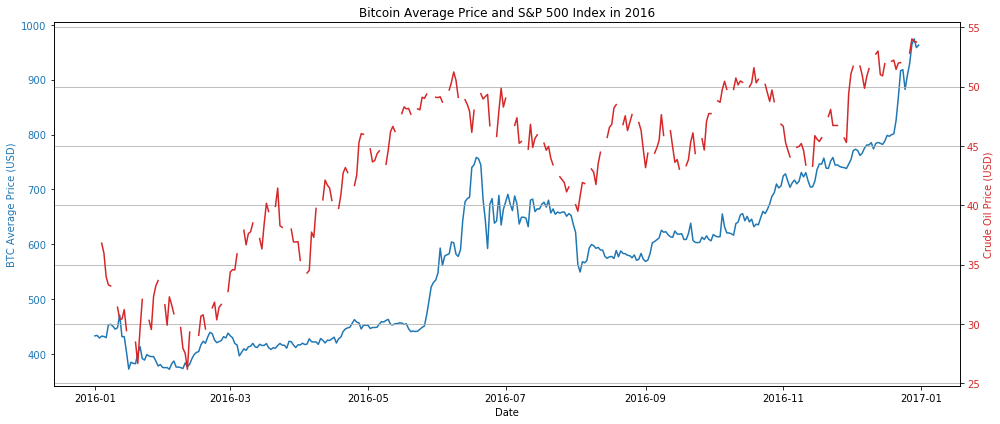

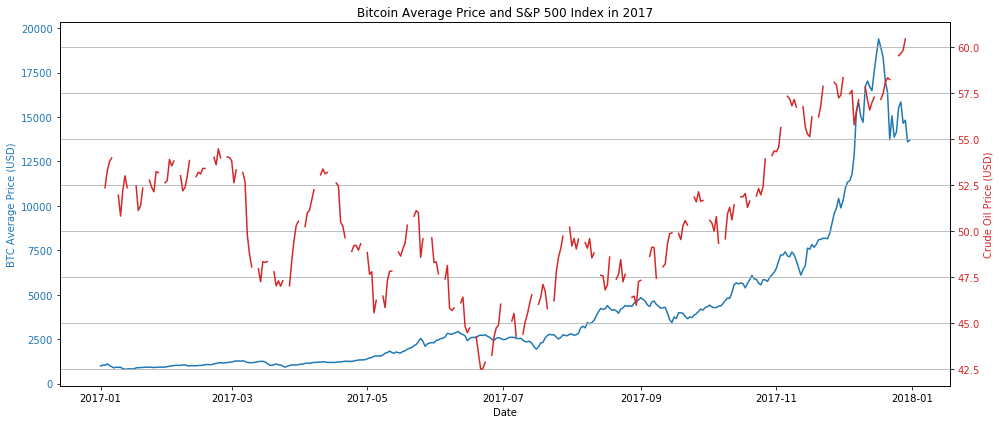

Bitcoin price and Crude Oil Price Correlation
Year                                               
2012                                      -0.503011
2013                                      -0.088359
2014                                       0.586355
2015                                      -0.609631
2016                                       0.754603
2017                                       0.604779

In [28]:
years = [2012, 2013, 2014, 2015, 2016, 2017]
bitcoin_crude_oil_year_corrletion = bitcoin_crude_oil_correlation_year_dependence(years)
bitcoin_crude_oil_year_corrletion

In [29]:
# Conclusion: The overall correlation between bitcoin average price and crude oil price is very low.
# Since correlation between bitcoin average price and crude oil price varies each year.
# Hence, bition can be used to hedge risk of traditional investment portfolio.

# Bitcoin and Other Crypocurrencies

In [30]:
# retrieve data of altcoins from Poloniex 
def get_json_data(json_url, cache_path):
    # Download and cache JSON data, return as a dataframe.
    try:        
        f = open(cache_path, 'rb')
        df = pickle.load(f)   
        print('Loaded {} from cache'.format(json_url))
    except (OSError, IOError) as e:
        print('Downloading {}'.format(json_url))
        df = pd.read_json(json_url)
        df.to_pickle(cache_path)
        print('Cached {} at {}'.format(json_url, cache_path))
    return df

In [31]:
base_polo_url = 'https://poloniex.com/public?command=returnChartData&currencyPair={}&start={}&end={}&period={}'
start_date = datetime.strptime('2012-01-01', '%Y-%m-%d') # get data from the start of 2015
end_date = datetime.now() # up until today
pediod = 86400 # pull daily data (86,400 seconds per day)

def get_crypto_data(poloniex_pair):
    '''Retrieve cryptocurrency data from poloniex'''
    json_url = base_polo_url.format(poloniex_pair, start_date.timestamp(), end_date.timestamp(), pediod)
    data_df = get_json_data(json_url, poloniex_pair)
    data_df = data_df.set_index('date')
    return data_df

In [32]:
# download exchange data for top nine altcoins
# Ethereum, Ripple, Bitcoin Cash, Litecoin, Monero, Dash, NEM, Ethereum Classic, Siacoin.
altcoins = ['ETH', 'XRP', 'BCH', 'LTC', 'XMR', 'DASH', 'XEM', 'ETC', 'SC']
altcoins_data = {}
for altcoin in altcoins:
    coinpair = 'BTC_{}'.format(altcoin)
    crypto_price_df = get_crypto_data(coinpair)
    altcoins_data[altcoin] = crypto_price_df

Loaded https://poloniex.com/public?command=returnChartData&currencyPair=BTC_ETH&start=1325404800.0&end=1525066959.174681&period=86400 from cache
Loaded https://poloniex.com/public?command=returnChartData&currencyPair=BTC_XRP&start=1325404800.0&end=1525066959.174681&period=86400 from cache
Loaded https://poloniex.com/public?command=returnChartData&currencyPair=BTC_BCH&start=1325404800.0&end=1525066959.174681&period=86400 from cache
Loaded https://poloniex.com/public?command=returnChartData&currencyPair=BTC_LTC&start=1325404800.0&end=1525066959.174681&period=86400 from cache
Loaded https://poloniex.com/public?command=returnChartData&currencyPair=BTC_XMR&start=1325404800.0&end=1525066959.174681&period=86400 from cache
Loaded https://poloniex.com/public?command=returnChartData&currencyPair=BTC_DASH&start=1325404800.0&end=1525066959.174681&period=86400 from cache
Loaded https://poloniex.com/public?command=returnChartData&currencyPair=BTC_XEM&start=1325404800.0&end=1525066959.174681&period=8

In [33]:
altcoins_data['ETH'].tail(2)

close     high       low      open   quoteVolume       volume  \
date                                                                           
2018-04-26  0.071486  0.07175  0.067945  0.069600  44267.315458  3100.220866   
2018-04-27  0.071974  0.07350  0.069847  0.071419  35940.460632  2568.177645   

            weightedAverage  
date                         
2018-04-26         0.070034  
2018-04-27         0.071456

In [34]:
# Calculate USD Price as a new column in each altcoin dataframe
for altcoin in altcoins_data.keys():
    altcoins_data[altcoin]['price_usd'] =  altcoins_data[altcoin]['weightedAverage'] * btc_usd_datasets['avg_btc_price_usd']
    
# Merge USD price of each altcoin into single dataframe 
cryptocurrencies = merge_dfs_on_column(list(altcoins_data.values()), list(altcoins_data.keys()), 'price_usd')

# Add BTC price to the dataframe
cryptocurrencies['BTC'] = btc_average_price['avg_btc_price_usd']

In [35]:
# plot all of the altocoin prices
df_scatter(cryptocurrencies, 'Cryptocurrency Prices (USD)', seperate_y_axis=False, y_axis_label='Altcoin Price (USD)', scale='log')

In [36]:
def correlation_heatmap(df, title, absolute_bounds=True):
    # Plot a correlation heatmap for the entire dataframe
    heatmap = go.Heatmap(
        z=df.corr(method='pearson').as_matrix(),
        x=df.columns,
        y=df.columns,
        colorbar=dict(title='Pearson Coefficient'),
    )
    
    layout = go.Layout(title=title)
    
    if absolute_bounds:
        heatmap['zmax'] = 1.0
        heatmap['zmin'] = -1.0
        
    fig = go.Figure(data=[heatmap], layout=layout)
    py.iplot(fig)

In [37]:
# Calculate the pearson correlation coefficients for cryptocurrencies in 2015
cryptocurrencies_2015 = cryptocurrencies[cryptocurrencies.index.year == 2015]
correlation_heatmap(cryptocurrencies_2015.pct_change(), "Cryptocurrency Correlations in 2015")
cryptocurrencies_2015.pct_change().corr(method='pearson')

BCH      DASH  ETC       ETH       LTC        SC       XEM       XMR  \
BCH   NaN       NaN  NaN       NaN       NaN       NaN       NaN       NaN   
DASH  NaN  1.000000  NaN  0.119265  0.467222  0.067126  0.377425  0.412406   
ETC   NaN       NaN  NaN       NaN       NaN       NaN       NaN       NaN   
ETH   NaN  0.119265  NaN  1.000000  0.165016 -0.033511  0.033498  0.025860   
LTC   NaN  0.467222  NaN  0.165016  1.000000  0.078964  0.322086  0.487601   
SC    NaN  0.067126  NaN -0.033511  0.078964  1.000000  0.064495  0.110494   
XEM   NaN  0.377425  NaN  0.033498  0.322086  0.064495  1.000000  0.237546   
XMR   NaN  0.412406  NaN  0.025860  0.487601  0.110494  0.237546  1.000000   
XRP   NaN  0.405888  NaN  0.012994  0.432939  0.026265  0.317658  0.318401   
BTC   NaN  0.648661  NaN  0.149445  0.735813  0.158184  0.390257  0.649226   

           XRP       BTC  
BCH        NaN       NaN  
DASH  0.405888  0.648661  
ETC        NaN       NaN  
ETH   0.012994  0.149445  
LTC   0.432939  0.735813  
SC    0.026265  0.158184  
XEM   0.317658  0.390257  
XMR   0.318401  0.649226  
XRP   1.000000  0.516965  
BTC   0.516965  1.000000

In [38]:
# Calculate the pearson correlation coefficients for cryptocurrencies in 2016
cryptocurrencies_2016 = cryptocurrencies[cryptocurrencies.index.year == 2016]
correlation_heatmap(cryptocurrencies_2016.pct_change(), "Cryptocurrency Correlations in 2016")
cryptocurrencies_2016.pct_change().corr(method='pearson')

BCH      DASH       ETC       ETH       LTC        SC       XEM  \
BCH   NaN       NaN       NaN       NaN       NaN       NaN       NaN   
DASH  NaN  1.000000  0.055356  0.200051  0.166265  0.066374  0.113693   
ETC   NaN  0.055356  1.000000 -0.125421 -0.049440  0.021282 -0.039611   
ETH   NaN  0.200051 -0.125421  1.000000  0.062988  0.188634  0.102300   
LTC   NaN  0.166265 -0.049440  0.062988  1.000000  0.063295  0.271364   
SC    NaN  0.066374  0.021282  0.188634  0.063295  1.000000  0.131601   
XEM   NaN  0.113693 -0.039611  0.102300  0.271364  0.131601  1.000000   
XMR   NaN  0.141587 -0.100374  0.104680  0.150003  0.055134  0.051412   
XRP   NaN  0.194588 -0.022602  0.155035  0.196348  0.054584  0.180753   
BTC   NaN  0.190704 -0.058878  0.128819  0.815468  0.088949  0.339661   

           XMR       XRP       BTC  
BCH        NaN       NaN       NaN  
DASH  0.141587  0.194588  0.190704  
ETC  -0.100374 -0.022602 -0.058878  
ETH   0.104680  0.155035  0.128819  
LTC   0.150003  0.196348  0.815468  
SC    0.055134  0.054584  0.088949  
XEM   0.051412  0.180753  0.339661  
XMR   1.000000  0.054153  0.147002  
XRP   0.054153  1.000000  0.209437  
BTC   0.147002  0.209437  1.000000

In [39]:
# Calculate the pearson correlation coefficients for cryptocurrencies in 2017
cryptocurrencies_2017 = cryptocurrencies[cryptocurrencies.index.year == 2017]
correlation_heatmap(cryptocurrencies_2017.pct_change(), "Cryptocurrency Correlations in 2017")
cryptocurrencies_2017.pct_change().corr(method='pearson')

BCH      DASH       ETC       ETH       LTC        SC       XEM  \
BCH   1.000000  0.493122  0.430908  0.321606  0.246571  0.238515  0.200554   
DASH  0.493122  1.000000  0.387156  0.508040  0.334971  0.290569  0.321091   
ETC   0.430908  0.387156  1.000000  0.602216  0.477052  0.296803  0.317344   
ETH   0.321606  0.508040  0.602216  1.000000  0.433036  0.372816  0.395048   
LTC   0.246571  0.334971  0.477052  0.433036  1.000000  0.335819  0.372976   
SC    0.238515  0.290569  0.296803  0.372816  0.335819  1.000000  0.328079   
XEM   0.200554  0.321091  0.317344  0.395048  0.372976  0.328079  1.000000   
XMR   0.244568  0.500539  0.448235  0.557573  0.433447  0.378238  0.332203   
XRP   0.044746  0.082827  0.105957  0.204708  0.314098  0.239326  0.259867   
BTC   0.050506  0.304919  0.414833  0.411737  0.409213  0.322904  0.317821   

           XMR       XRP       BTC  
BCH   0.244568  0.044746  0.050506  
DASH  0.500539  0.082827  0.304919  
ETC   0.448235  0.105957  0.414833  
ETH   0.557573  0.204708  0.411737  
LTC   0.433447  0.314098  0.409213  
SC    0.378238  0.239326  0.322904  
XEM   0.332203  0.259867  0.317821  
XMR   1.000000  0.220038  0.410943  
XRP   0.220038  1.000000  0.111950  
BTC   0.410943  0.111950  1.000000

In [40]:
# Conclusion: The overall correlations among cryptocurrency prices are increasing in time.
# The reason of increase in the correlations among cryptocurrencies is probably because of 
# that fact that the incredible return rate in cryptocurrencies in 2017 had attracted a lot
# of attention from public. More and more individual and institutional investors including 
# hedge funds are involving into investing bitcoin and altcoins. Hence, cryptocurrencies 
# besides bitcoin can also be used to diversify traditional investment portfolio.

In [41]:
# Summary: 
# 1. Bition mining difficulty can be utilized to prdict bitcoin price.
# 2. Bition average price can be used to forecast the overall US stock market sentiment.
# 3. Bition can be exploited to hedge risk of traditional investment portfolio.
# 4. Altcoins can be used to diversify traditional investment portfolio.

In [42]:
# To-do Lists:
# 1. Scrape data regarding bitcoin and other cryptocurrencies from Google, Facebook, 
#    Twitter, Reddit, Coindesk etc. as input for machine learning model 
# 2. Train a predictive machine learning model by using linear regression, xgboost, 
#    and recurrent neural network etc. on the collected data to predict bitcoin's 
#    future price.
# 3. Backtest the developed machine learning model to see how good machine learning 
#    algorithms can be when they are applied to quantitative finance.